# Advent of Code 2018
We have to save christmas by solving 50 puzzles and going back in time.

First I define some utility functions, e.g. to retrieve the input file for a given day using the sessioncookie stored in the file `cookie`.

In [1]:
import requests
import os
def Input(day):
    if not os.path.exists(f'day{day}.input'):
        print(f'downloading input file for day {day}')
        with open('cookie') as f:
            cookie = f.read().strip()
        resp = requests.get(f'https://adventofcode.com/2018/day/{day}/input',
                            cookies={'session': cookie})
        if resp.status_code == 200:
            with open(f'day{day}.input', 'w') as f:
                f.write(resp.text)
        else:
            print(f'Coockie might be expired: {res.status_code} {res.reason}')
    with open(f'day{day}.input') as f:
        # discard the last line, since it is empty
        return f.read().split('\n')[:-1]
from matplotlib import pyplot as plt
%matplotlib inline

## Day 1
We have a frequency-changing device, so first we look at the end-frequency after all changes in the file are applied to the start-frequency of 0. The second question is, which frequency is reached twice first, possibly having to loop the input multiple times

In [2]:
def end_frequency(input):
    return sum([ int(l) for l in input])
assert end_frequency(['+1']) == 1
assert end_frequency([-1, 2,-2,5]) == 4
end_frequency(Input(1))

490

In [3]:
def find_duplicate_frequency(changes):
    reached_frequencies = set([0])
    current_frequency = 0
    for i in range(10**100):
        for l in changes:
            current_frequency += int(l)
            if current_frequency in reached_frequencies:
                #print(f'iteration: {i}, {current_frequency}')
                return current_frequency
            reached_frequencies.add(current_frequency)
assert find_duplicate_frequency([1,-1]) == 0
assert find_duplicate_frequency([4, -2]) == 4
find_duplicate_frequency(Input(1))

70357

## Day 2
The special fabric for Santa's new suit has gone missing. After sneaking into the storageroom, I scan the boxes and obtain a list of boxids. First, I have to make sure, every box has been scanned by computing the checksum over all boxids by multiplying the number of ids containing the same character 2 and 3 times respectively.

In [4]:
from collections import Counter
def box_checksum(boxids):
    triples = 0
    doubles = 0
    counters = [Counter(bid) for bid in boxids]
    doubles, triples = sum([1 for c in counters if 2 in c.values()]), sum([1 for c in counters if 3 in c.values()])
    return doubles * triples

assert box_checksum(['aa']) == 0
assert box_checksum(['aa', 'abbaa']) == 2
assert box_checksum(['abc', 'aaaab', 'abab', 'abcabb']) == 2
box_checksum(Input(2))

4980

So we scanned all the boxes, so now I can search for the right 2 boxes. They where manifactured very close to each other, meaning their ids are almost identical. Only the char at one position is different. So we have to return the remainder of the id.

In [5]:
import itertools
def common_chars_in_boxids(boxids):
    for s in itertools.product(boxids,repeat=2):
        matches = [ pair[0] for pair in zip(s[0],s[1]) if pair[0] == pair[1]]
        if len(s[0])-1 == len(matches):
            #print(s,matches)
            return "".join(matches)

common_chars_in_boxids(['abc','cde','bbc']) == 'bc'
common_chars_in_boxids(['axc','cde','abc']) == 'ac'
common_chars_in_boxids(Input(2))

'qysdtrkloagnfozuwujmhrbvx'

## Day 3
While the elves have found the fabric, they can't decide how to cut it. They each want to cut a rectangle out of it, specified like `#<ID> @ <off_left>,<off_right>: <width>x<height>`. As a helping hand, I have to determine how many squares are claimed by more than one rectangle.

We mark each square of the sheet with the id of each rectangle containing it. Now we only have to count all squares having more than one mark.

In [6]:
from collections import defaultdict
import re

test_claims = ["#1 @ 1,3: 4x4","#2 @ 3,1: 4x4","#3 @ 5,5: 2x2"]

def get_claims(lines):
    """ Yields (id, off_left, off_right, width, height)"""
    for l in lines:
        rv = tuple(re.findall('\\d+',l))
        assert len(rv) == 5
        yield rv
assert list(get_claims(test_claims))[0] == ('1','1','3','4','4')

def mark_sheet(claims):
    marks = defaultdict(set)
    for c in claims:
        for x in range(int(c[1]), int(c[1])+int(c[3])):
            for y in range(int(c[2]), int(c[2])+int(c[4])):
                marks[(x,y)].add(c[0])
    return marks

def count_multi_marks(claims):
    return len([1 for x in mark_sheet(claims).values() if len(x) > 1])

assert count_multi_marks([(0,2,2,4,4), (1,1,1,1,1)]) == 0
assert count_multi_marks([(0,2,2,4,3), (1,1,1,2,2)]) == 1
assert count_multi_marks(get_claims(test_claims)) == 4
assert count_multi_marks([(0,2,2,4,3), (1,1,1,2,2), (2,2,2,1,1)]) == 1

count_multi_marks(get_claims(Input(3)))

118322

There seems to be one claim, that has no intersections with any of the others. If I find it, perhaps the elves can actually work from there.

In [7]:
def find_best_claim(claims):
    all_ids = set()
    intersecting_ids = set()
    for v in mark_sheet(claims).values():
        if len(v) > 1:
            intersecting_ids.update(v)
            #print(intersecting_ids)
        all_ids.update(v)
    # there has to be one
    return all_ids.difference(intersecting_ids).pop()
assert find_best_claim(get_claims(test_claims)) == '3'
find_best_claim(get_claims(Input(3)))

'1178'

## Day 4
Having to break into a security room guarded by a guard. Since they seem to be sleepy I just have to figure out, which guard and time is the ideal combination. Strategy 1: Use the most sleepy guard and then take the time he was asleep at the most.

I'll first try the easy solution of just accumulating the sleeping minutes of every guard into a Counter. By using the right order within tuples, I can condense finding the `sleepy_guard` into one `max()`. The submission is `chosen_minute * guardId`.

In [8]:
def translate_guard_plan(lines):
    asleep = defaultdict(Counter)
    last_entry = (-1,-1,"x")
    for l in sorted(lines):
        numbers = re.findall("\\d+", l)
        gid = int(numbers[5]) if len(numbers) == 6 else last_entry[0]
        current_entry = (gid, int(numbers[4]), l.split()[-1])
        if last_entry[2] == "asleep" and current_entry[2] == "up":
            asleep[current_entry[0]].update(range(last_entry[1], current_entry[1]))
        elif last_entry[2] == "asleep" and current_entry[2] == "shift":
            raise AssertionError("Guardchange while sleeping is not accounted for")
        last_entry = current_entry
    return asleep
assert translate_guard_plan(["[1518-11-01 00:05] wakes up",
                             "[1518-11-01 00:00] Guard #1337 begins shift",
                             "[1518-11-01 00:01] falls asleep"]) == {1337: Counter([1,2,3,4])}

def best_minute_by_guard(plan):
    sleepy_guard = max([(sum(sleeping.values()), guard) for guard, sleeping in plan.items()])[1]
    return plan[sleepy_guard].most_common(1)[0][0] * sleepy_guard
assert best_minute_by_guard({1:Counter([1,2,2,2,2,2]), 2:Counter([10,10,10,11,11,11,11])}) == 2 * 11
best_minute_by_guard(translate_guard_plan(Input(4)))

101194

Strategy 2: Find the minute were one guard sleeps more than any other guard on any other minute.

In [9]:
def best_guard_by_minute(plan):
    sleepiest_minute = (-1,(-1,-1))
    for guard, sleeping in plan.items():
        if sleepiest_minute[1][1] < sleeping.most_common(1)[0][1]:
            sleepiest_minute = (guard, sleeping.most_common(1)[0])
    return plan[sleepiest_minute[0]].most_common()[0][0] * sleepiest_minute[0]
assert best_guard_by_minute({1:Counter([1,2,2,2,2,2]), 2:Counter([10,10,10,11,11,11,11])}) == 1 * 2
best_guard_by_minute(translate_guard_plan(Input(4)))

102095

## Day 5
I have to reduce a long line (a polymer) of positive/negative units represented by upper/lowercase letters. A negative and a positive unit react and destroy each other, for example `abBAc = aAc = c`.

The solution will work with a stack of unreacted units. The current letter can either react with the top of the stack, consuming the top and the current unit or be pushed onto the stack. The number of units remaining on the stack after iterating through the polymer is the answer to the puzzle.

In [10]:
def reduce_polymer(polymer):
    reduced = [1] # need a unreactable bottom of the stack to avoid index errors
    for c in polymer:
        if (c.islower() and c.capitalize() == reduced[-1]) or (c.isupper() and c.lower() == reduced[-1]):
            reduced.pop()
        else:
            reduced.append(c)
    return len(reduced) - 1
assert reduce_polymer('aABbc') == 1
assert reduce_polymer('vBaAbV') == 0
assert reduce_polymer('dabAcCaCBAcCcaDA') == 10
reduce_polymer(Input(5)[0])

11194

What is the shortest polymer I can obtain by removing one letter paitr?

In [11]:
import string
def alter_polymer(polymer):
    return min([reduce_polymer(re.sub(f"[{c}{c.upper()}]",'', polymer)) for c in string.ascii_lowercase])
assert alter_polymer('aBBA') == 0
assert alter_polymer('aBBAcAACCAAc') == 2
alter_polymer(Input(5)[0])

4178

## Day 6
I finished up in 1518, so now i am travelling through time again. But that timetravelthing does not work again. It is just giving me coordinates of things. I should pick out the one that is the furthest away from all others, to minimize the danger.

To find that, I will floodfill the plane from each point, searching for the one leading to the largest area, while not being infinite.

*Note*: I was thinking of removing my failed attempt of implementing the floodfill but I find it kind of amusing to look at. Even the second try went very wrong, until I finally figured out that my Inputparsing went really wrong...
1. `'123, 354'` => `(1,1)`
1. `'123, 354'` => `(1,2)`
1. `'123, 354'` => `(123,354)`... Finally

In [12]:
def find_largest(starting):
    planesize = 400
    plane = [ [(10**4,-1) for i in range(planesize)] for j in range(planesize)]
    front = [(int(p[0]),int(p[1])) for p in starting]
    def mark_point(plane, point, new_dist, new_did):
        if point[0] < 0 or point[0] >= planesize or point[1] < 0 or point[1] >= planesize:
            return None
        dist, did = plane[point[0], point[1]]
        if new_dist < dist:
            dist = new_dist
            did = new_did
        elif new_dist == dist:
            did = -1
        plane[point[0]][point[1]] = (dist, did)
        return (point[0], point[1])
    def do_flood_step(plane, front):
        new_front = []
        for x,y in front:
            dist, did = plane[x][y]
            tmp = mark_point(plane, plane[x-1][y], dist+1, did)
            if tmp != None: new_front.append(tmp)
            tmp = mark_point(plane, plane[x+1][y], dist+1, did)
            if tmp != None: new_front.append(tmp)
            tmp = mark_point(plane, plane[x][y-1], dist+1, did)
            if tmp != None: new_front.append(tmp)
            tmp = mark_point(plane, plane[x][y+1], dist+1, did)
            if tmp != None: new_front.append(tmp)
        return plane, new_front
    while len(front) > 0:
        print(len(front))
        plane, front = do_flood_step(plane,front)
#floodfill([ p.split(', ') for p in Input(6) ])
#map(lambda p: (int(p[0]),int(p[1])), b)

def find_largest2(starting, size=450):
    infinite = set()
    #print(len(starting), starting)
    counter = Counter()
    for x in range(size):
        for y in range(size):
            #print([(sum([*p, -x, -y]), f"{p[0],p[1]} - {x} -{y}") for i, p in enumerate(starting)])
            min_l = sorted([(abs(p[0]-x) + abs( p[1] -y), i) for i, p in enumerate(starting)])
            #if(min_l[0][1] != 28 and min_l[0][1] != 8):
                #print(min_l[:3])
            i = min_l[0][1]
            if min_l[0][0] < min_l[1][0]:
                counter.update([i])
            elif i not in counter:
                pass
                #print("unknown:",min_l[:2])
            #print(f"{x},{y} -> startin[{i}]")
            if x == 0 or x == size-1 or y == 0 or y == size-1:
                infinite.add(i)
    print('infinite',infinite)
    #print('counter',len(counter),counter.most_common())
    for i, count in counter.most_common():
        if i not in infinite:
            print(i, count)
            return count
assert find_largest2([(1,1),(5,1),(5,5),(1,5),(3,3)], 7) == 5 # only (2,2) is not extending to infinite
find_largest2(list(map(lambda p: (int(p[0]),int(p[1])),map(lambda p: p.split(', '),Input(6)))))

infinite {0, 1, 2, 3}
4 5
infinite {0, 2, 4, 5, 7, 11, 14, 17, 19, 20, 23, 24, 25, 27, 30, 32, 33, 35, 36, 37, 39, 40, 41, 45}
10 3894


3894

Perhaps its better to choose a spot as close to all points as possible. So how many spots are there, for which the total distance to all points is less than `10000`.

In [13]:
def get_spots_closest(starting, size=400, threshold=10000):
    count = 0
    for x in range(size):
        for y in range(size):
            distance2all = sum([ abs(p[0]-x)+abs( p[1] -y) for p in starting])
            if distance2all < threshold:
                count+=1
    return count
get_spots_closest(list(map(lambda p: (int(p[0]),int(p[1])),map(lambda p: p.split(', '),Input(6)))))

39398

## Day 7
I reached 1018, immediately spotting elves carring a building parts of a sleigh. The instructions for building it form a directed graph, e.g. part X has to be finished before starting part Y. If there are multiple parts ready, we go by the alphabetical order.

I collect the edges into a dict containing all the parts that have to be finished first. Then I only have to take one out that has no precondition, clearing out the dict each step.

In [14]:
def sleigh_building_steps(steps):
    all_stages = set()
    result = ""
    for pre, post in steps:
        all_stages.update([pre,post])
    while len(all_stages) > 0:
        next_stage = [ stage for stage in all_stages if stage not in [ post for _,post in steps]]
        #print(min(next_stage),next_stage)
        result+=min(next_stage)
        all_stages.remove(min(next_stage))
        steps = [ (pre, post) for pre, post in steps if pre != min(next_stage)]
    return result
assert sleigh_building_steps([('A','B'), ('B','C')]) == 'ABC'
assert sleigh_building_steps([('A','B'), ('B','C'), ('D','B')]) == 'ADBC'
sleigh_building_steps([re.findall('[A-Z]', l)[1:] for l in Input(7)])

'OCPUEFIXHRGWDZABTQJYMNKVSL'

### Stage 2 Try 1
Now each step takes `60 + letter` seconds, so `A` takes 61, `B` takes 62, and so on. But luckily the there are 4 Elves willing to help me build the sleigh, so it should not take to long to fully assemble it. A Stage is only appended to the Output, once it has been completed.

In [15]:
def assemble_sleigh_with_elves(steps, base_time=60, workers=5, debug=False):
    result = ""
    working = []
    remaining = set([pre for pre, _ in steps] + [post for _, post in steps])
    ready = [ stage for stage in remaining if stage not in [ post for _,post in steps] and
                                              stage not in [ stage for stage,_ in working]]
    time = -1
    if debug:
        print('time, result, currently worked on stages, finished stage')
    while len(remaining) > 0:
        time+=1
        done = [stage for stage, remaining in working if remaining - 1 == 0]
        steps = [ (pre, post) for pre, post in steps if pre not in done]
        assert len([pre for pre,_ in steps if pre in done]) == 0
        remaining = remaining.difference(set(done))
        assert len([d for d in done if d in remaining]) == 0
        working = [(stage, remaining-1) for stage, remaining in working if remaining - 1 > 0]
        ready = [ stage for stage in remaining if stage not in [ post for _,post in steps] and
                                                  stage not in [ stage for stage,_ in working]]
        result += "".join(sorted(done))
        if len(working) < workers:
            for i in range(min([len(ready),workers - len(working)])):
                next_step = min(ready)
                working.append((next_step, ord(next_step) - ord('A') + 1 + base_time))
                ready.remove(next_step)
        if len(done) > 0 and debug:
            print(time, result, working, done)
    return result, time
assert assemble_sleigh_with_elves([('B','A'),('A','C'), ('D','C')], base_time=0, workers=2) == ('BADC', 7)
assert assemble_sleigh_with_elves([('C','A'),('C','F'),('A','B'),('A','D'),
                                   ('B','E'),('D','E'),('F','E')], base_time=0, workers=2) == ('CABFDE', 15)
assemble_sleigh_with_elves([re.findall('[A-Z]', l)[1:] for l in Input(7)], debug=True)

time, result, currently worked on stages, finished stage
75 O [('P', 1), ('C', 63)] ['O']
76 OP [('C', 62), ('U', 81), ('X', 84)] ['P']
138 OPC [('U', 19), ('X', 22)] ['C']
157 OPCU [('X', 3), ('E', 65)] ['U']
160 OPCUX [('E', 62), ('H', 68)] ['X']
222 OPCUXE [('H', 6), ('F', 66), ('I', 69)] ['E']
228 OPCUXEH [('F', 60), ('I', 63), ('R', 78), ('W', 83), ('Z', 86)] ['H']
288 OPCUXEHF [('I', 3), ('R', 18), ('W', 23), ('Z', 26)] ['F']
291 OPCUXEHFI [('R', 15), ('W', 20), ('Z', 23)] ['I']
306 OPCUXEHFIR [('W', 5), ('Z', 8), ('G', 67)] ['R']
311 OPCUXEHFIRW [('Z', 3), ('G', 62), ('D', 64)] ['W']
314 OPCUXEHFIRWZ [('G', 59), ('D', 61), ('A', 61)] ['Z']
373 OPCUXEHFIRWZG [('D', 2), ('A', 2)] ['G']
375 OPCUXEHFIRWZGAD [('B', 62), ('T', 80)] ['D', 'A']
437 OPCUXEHFIRWZGADB [('T', 18)] ['B']
455 OPCUXEHFIRWZGADBT [('Q', 77), ('Y', 85)] ['T']
532 OPCUXEHFIRWZGADBTQ [('Y', 8), ('J', 70)] ['Q']
540 OPCUXEHFIRWZGADBTQY [('J', 62), ('M', 73)] ['Y']
602 OPCUXEHFIRWZGADBTQYJ [('M', 11)] ['J']
613 OPCUX

('OPCUXEHFIRWZGADBTQYJMNKVSL', 991)

I could not figure out, why my answer `OPCUXEHFIRWZGADBTQYJMNKVSL` was not accepted, even though the code worked on the given example and my own. I even tried different manually changing the order of stages, which finished at the same time, and printing the graph with `dot` to see if i missed anything.

### Stage 2 Try 2
After giving up and going to sleep after 2h, I came back the next day and figured that I should reimplement my solution, to make sure I implemented the correct solution.

In [16]:
def assemble_sleigh_with_elves_2(steps, base_time=60, workers=5):
    step_dict = defaultdict(set)
    remaining_stages = set()
    for pre, post in steps:
        step_dict[pre].add(post)
        remaining_stages.update([pre, post])
    def blocked():
        return set.union(set(),*list(step_dict.values()))
    def ready():
        return sorted(list(remaining_stages.difference(blocked())))
    # setup loop variables
    finished_at = defaultdict(list)
    def working():
        return sum([l for l in finished_at.values()], [])
    time = -1
    result = ''
    while len(remaining_stages) > 0:
        time+=1
        # remove finished stages
        result += "".join(sorted(list(finished_at[time])))
        for stage in finished_at[time]:
            if stage in step_dict:
                del(step_dict[stage])
            remaining_stages.remove(stage)
        del(finished_at[time])
        
        # shedule work
        for stage in ready():
            if len(working()) < workers and stage not in working():
                finished_at[time + ord(stage)-ord('A')+base_time+1].append(stage)
    return result, time
        
assert assemble_sleigh_with_elves_2([('B','A'),('A','C'), ('D','C')], base_time=0, workers=2) == ('BADC', 7)
assert assemble_sleigh_with_elves_2([('C','A'),('C','F'),('A','B'),('A','D'),
                                     ('B','E'),('D','E'),('F','E')], base_time=0, workers=2) == ('CABFDE', 15)
# check if both implementations do the same thing
assert assemble_sleigh_with_elves_2([re.findall('[A-Z]', l)[1:] for l in Input(7)]) == (
    assemble_sleigh_with_elves([re.findall('[A-Z]', l)[1:] for l in Input(7)]))
assemble_sleigh_with_elves_2([re.findall('[A-Z]', l)[1:] for l in Input(7)])


('OPCUXEHFIRWZGADBTQYJMNKVSL', 991)

Aaaand both versions returned the same result... so reading again I noticed, that the answer should instead be the **amount of time** necessary to finish all steps. 😡😡😡

Since I already tracked the time taken, I quickly added it to the output, finally completing part 2 of day 7.

## Day 8
Have to decode a tree with metadata from a long line. first two digits are the number of children and the number of metadata respectively. Then follows the serialization of the children and after that the serialization of the metadata. Therefore it is a depth-first walk through the tree.

In [17]:
def reverse_depth_first(ints):
    """Returns the sum of metadata of the children + the remainder of the ints"""
    next_children = ints[0]
    next_metadata = ints[1]
    ints = ints[2:]
    sum_children = 0
    for i in range(next_children):
        tmp, ints = reverse_depth_first(ints)
        sum_children+= tmp
    metadata = ints[:next_metadata]
    ints = ints[next_metadata:]
    #print(f"node children={next_children} meta={next_metadata}, sum={sum_children}+{sum(metadata)}, {ints}")
    return sum_children + sum(metadata), ints
assert reverse_depth_first([0,2,5,7]) == (5+7, [])
assert reverse_depth_first([2,1,1,1,0,1,5,7,0,1,11,13]) == (5+7+11+13,[])
assert reverse_depth_first([2, 3, 0, 3, 10, 11, 12, 1, 1, 0, 1, 99, 2, 1, 1, 2]) == (138, [])
reverse_depth_first(list(map(lambda i: int(i), Input(8)[0].split())))

(45750, [])

More or less the same problem, only this time, the value of a node with no children is still the sum of metadata, while a node with children uses its metadata to reference which values of the childs to sum up.

In [18]:
def reverse_depth_first_alternate(ints):
    num_children, num_meta = ints[:2]
    ints = ints[2:]
    sum_children = [0]
    for i in range(num_children):
        child, ints = reverse_depth_first_alternate(ints)
        sum_children.append(child)
    metadata = ints[:num_meta]
    ints = ints[num_meta:]
    if num_children == 0:
        #print('0child:', sum(metadata), ints)
        return sum(metadata), ints
    else:
        return sum([sum_children[i] for i in metadata if i < len(sum_children)]), ints
assert reverse_depth_first_alternate([0,2,1,2]) == (3,[])
assert reverse_depth_first_alternate([3,7,0,1,10,0,1,20,0,1,30,0,1,1,2,3,4,5]) == (10+10+20+30, [])
reverse_depth_first_alternate(list(map(lambda i: int(i), Input(8)[0].split())))

(23266, [])

## Day 9
The elves want to play a game to pass the time. Adding marbles in a circle always with on space in beetween. Only on a marble with the value divisable by 23, the player keeps the marble and takes the marble 7 places counterclockwise from the last one. The added value of those marbles is added to the players score. The game continues with the marble directly to the right of the removed one.

I bet there is a nice mathmatical formula for this, but i will just simulate the game to obtain the highest score of the game.

In [19]:
def winner_of_elven_game(players, last, debug=0):
    ring = [0,1]
    score = [0 for i in range(players)]
    current = 1
    for i in range(2,last+1):
        if i % 23 != 0:
            current = (current+2)%len(ring)
            ring.insert(current, i)
            #print(i%players, current, ring[current])
        else:
            current = (current - 7)%len(ring)
            if debug > 1:
                print(f"{i:7d}: player {i%players:3d} now has " +
                      f"{score[i%players]}+{i}+{ring[current]}\t= {i+ring[current]+score[i%players]}")
            score[i%players] += i+ring[current]
            del ring[current]
        if debug > 0 and i % (last / 100) == 0:
            print(i, i/last)
    return max(score)

assert winner_of_elven_game(9, 25) == 32
assert winner_of_elven_game(10,1618) == 8317
assert winner_of_elven_game(13, 7999) == 146373
assert winner_of_elven_game(17, 1104) == 2764
assert winner_of_elven_game(21, 6111) == 54718
assert winner_of_elven_game(30, 5807) == 37305
winner_of_elven_game(*map(int,re.findall('\d+', Input(9)[0])))

390592

After making sure, the answer actually needs computing `71522*100` marbles, I start the incremental implementation, while searching for a pattern to exploit to be able to provide a cleaner solution.

In [20]:
def winner_of_elven_game_bigger():
    players, last = (*map(int,re.findall('\d+', Input(9)[0])),)
    print(players,last)
    winner_of_elven_game(players, last*100, debug=1)
#%time winner_of_elven_game_bigger()

In [21]:
# less inserting between values, should speed things up
def winner_of_elven_game_smart(players,last, scale = 1):
    return winner_of_elven_game_recurse(players, last*scale, [0 for i in range(players)], [0,1], 2)
def winner_of_elven_game_recurse(players, last, score, current, next_num, debug=False):
    if debug:
        print(f"in={len(current)}, next={next_num}")
    offset = 0
    result = []
    def take1(n=1):
        nonlocal offset
        for i in range(n):
            result.append(current[offset])
            offset+=1
    def take2(n=1):
        nonlocal next_num
        for i in range(n):
            if next_num % 23 == 0:
                next_num+=1
            result.append(next_num)
            next_num+=1
    while (offset < 10 and offset< len(current)) or offset < len(current)-5:
        take1()
        take2()
        if (next_num + 4) % 23 == 0: # uses 4 from current
            score[next_num%players] += current[offset]+next_num+4
            #if max(score) >= 146373:
            #   debug = True
            if debug:
                print(f"new score {score} from {current[offset]} + {next_num}")
            offset += 1
            take2()
            take1()
            result.append(next_num+4)
            take2()
            result.append(next_num+4)
            take1()
            result.append(next_num+5)
            take2()
            result.append(next_num+5)
            take1()
            result.append(next_num+6)
            take2()
            result.append(next_num+6)
            next_num+=7
        elif next_num > last:
            break
        if debug:
            print(f"result during loop {len(result)}")
    if debug:
        print(f"while done @{next_num} {len(result)}")
    if next_num > last:
        #print(f"returning {max(score)} from {score}")
        #print(current,result)
        return max(score)
    # reset the offset to 0 by rotating the ring of marbles
    return winner_of_elven_game_recurse(players, last, score, current[offset:] + result, next_num)

assert winner_of_elven_game_smart(9, 35) == 32
assert winner_of_elven_game_smart(10,1618) == 8317
#assert winner_of_elven_game_smart(13, 7999) == 146373
assert winner_of_elven_game_smart(17, 1104) == 2764
assert winner_of_elven_game_smart(21, 6111) == 54718
assert winner_of_elven_game_smart(30, 5807) == 37305
%time winner_of_elven_game_smart(*map(int,re.findall('\d+', Input(9)[0])), scale=100)

CPU times: user 4.43 s, sys: 127 ms, total: 4.56 s
Wall time: 4.56 s


3277920293

Interestingly, the testcases are not completely working but the result was accepted.

But the second version faster by at least a factor 50. The naive version has to copy a large part of the list on every insert (since it has to insert inbetween other entries. The new version always only appends to a list or adds lists, which are linear operations and less copying of values.

The hard part is how to fill the result list, when a number divisible by 23 is coming up. It only worked after double-checking the newly added values at least twice.

## Day 10
The elves need to find the right way by looking at the stars. They form a message in the sky, but I don't want to wait for it to actually appear.

So lets speed up time a little by moving the stars using programming. Since it is not clear, when the message will appear I need some kind of heuristic to determine when to stop. The first plan is to just look for the average amount of direct neighbors of each star. If they form letters that number should probably be somewhere close to 2?

The stars after 10036 seconds
................................................................
....###.....###..#....#..######..#....#..#....#..######..#####..
.....#.......#...#....#.......#..#....#..#...#...#.......#....#.
.....#.......#....#..#........#..#....#..#..#....#.......#....#.
.....#.......#....#..#.......#...#....#..#.#.....#.......#....#.
.....#.......#.....##.......#....######..##......#####...#####..
.....#.......#.....##......#.....#....#..##......#.......#......
.....#.......#....#..#....#......#....#..#.#.....#.......#......
.#...#...#...#....#..#...#.......#....#..#..#....#.......#......
.#...#...#...#...#....#..#.......#....#..#...#...#.......#......
..###.....###....#....#..######..#....#..#....#..#.......#......
................................................................


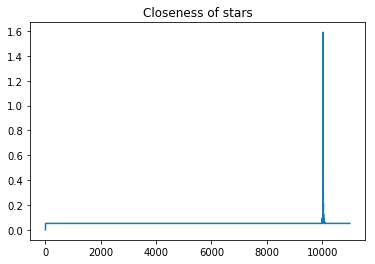

In [22]:
def neighbors(point, diagonals=False, include_self=False):
    yield point[0]-1, point[1]
    if diagonals:
        yield point[0]-1, point[1]-1
        yield point[0]-1, point[1]+1
        yield point[0]+1, point[1]-1
        yield point[0]+1, point[1]+1
    yield point[0]+1, point[1]
    if include_self:
        yield point
    yield point[0], point[1]+1
    yield point[0], point[1]-1
def average_neighbors(points):
        n = 0
        for point in points:
            for neighbor in neighbors(point):
                if neighbor in points:
                    n+=1
        return n/len(points)
assert average_neighbors([(1,1),(0,1),(1,0),(1,2),(2,1)]) == (4+4*1)/5
def print_2d(x=None,y=None,width=None,height=None,points=None,f=None):
    if x == None:
        x = min([p[0] for p in points]) - 1
    if width == None:
        width = max([p[0] for p in points]) - x + 2
    if y == None:
        y = min([p[1] for p in points]) - 1
    if height == None:
        height = max([p[1] for p in points]) - y + 2
    if f == None:
        f = lambda x,y: '#' if (x,y) in points else '.'
    for j in range(y,y+height):
            for i in range(x, x+width):
                print(f(i,j), end='')
            print('')

def speed_up_the_stars(stars, known_time=-1):
    averages = [0]
    for i in range(1,11000):
        stars = [(x+dx, y+dy, dx, dy) for x, y, dx, dy in stars]
        #print(stars[0], stars[10])
        star_points = set([(x,y) for x,y,_,_ in stars])
        averages.append(average_neighbors(star_points))
        if known_time == -1 and averages[-1] > max(averages[:-1]):
            print(i, averages[-1])
        if i == known_time:
            print(f"The stars after {i} seconds")
            print_2d(points=star_points)
    plt.title('Closeness of stars')
    plt.plot(averages)

speed_up_the_stars(map(lambda l: (int(l[0]),int(l[1]),int(l[2]),int(l[3])),
                       [re.findall('-?\d+', l) for l in Input(10)]), known_time=10036)

## Day 11
I am travelling through time again, but the watch seems to be lacking power. I guess I have to pick the power-cells that have the most power left in a small radius.

Luckily i already have some functions operating on points, now I only have to find the local maximum of 3x3 values in a 300x300 grid. Just iterating through all 3x3 points and finding the max after adding the values should do the trick.

In [23]:
day_11_input = 1309
iterable_add = lambda xs,ys: tuple(x + y for x, y in itertools.zip_longest(xs, ys))
def calculate_power_level(x, y, grid_serial=day_11_input):
    return (((x + 10) * y + grid_serial) * (x+10)) // 100 % 10 - 5
assert calculate_power_level(3,5,8) == 4
assert calculate_power_level(122, 79,57) == -5
assert calculate_power_level(217,196,39) == 0
assert calculate_power_level(101,153,71) == 4
def find_max_fuel_value(grid_serial=day_11_input):
    max_val = (-10**3, (0, 0))
    for y in range(2,300-1):
        for x in range(2,300-1):
            power = 0 #calculate_power_level(dx,ny,grid_serial)
            for nx,ny in neighbors((x,y),diagonals=True, include_self=True):
                power += calculate_power_level(nx,ny,grid_serial)
            max_val = max((power,(x,y)), max_val)
    #print(max_val)
    #print_2d(32,44,6,5,f=lambda i,j: f"{calculate_power_level(i,j,grid_serial):4d}")
    return iterable_add(max_val[1],(-1,-1)) # get the top left corner of the 3x3
assert find_max_fuel_value(18) == (33,45)
assert find_max_fuel_value(42) == (21,61)
find_max_fuel_value()

(20, 43)

I discover a dial at the side of the watch, which makes the selection grid adjustable from a small `1x1` to the whole `300x300`. After the maximization of the value of the grid, its grid size will be part of the result.

The first try of just using 3 nested for-loop got really slow after size 25. So I remembered the lectures about dynamic programming and added caching of already computed results. A square of size 30x30 can be computed by adding the values of the 4 inner 15x15 squares. As a final speedup for squares with a prime square-size `n`, I deconstructed a side into `2*n/2 + 1`. This means I can reuse the sizes from `n/2` and only have to sum a small number of energy levels for the edges with the maximum `x` and `y`.

In [24]:
def calculate_power_level_varying(grid_serial=day_11_input, manual_size_cap=300):
    max_val = (-10*3, (0, 0, 0))
    old_values = defaultdict(dict)
    old_values[10**3] = {}
    for size in range(1,manual_size_cap):
        dsize = max([k for k in old_values.keys() if size % k == 0]) if size > 1 else 1
        if dsize == 1 and size > 20: # these get really slow, if done with dsize=1, faster to only add the max x/y edge
            dsize = size//2
        if size % 10 == 0:
            print("#", end='')
        for x in range(1,302-size):
            for y in range(1,302-size):
                if size > 1:
                    if size % dsize == 0:
                        endx = x+size
                        endy = y+size
                    else:
                        endx = x+size-dsize
                        endy = y+size-dsize
                    val = sum([old_values[dsize][(nx,ny)] for nx in range(x,endx,dsize)
                                                          for ny in range(y,endy,dsize)])
                    if size % dsize != 0:
                        val += sum([old_values[1][(nx,y+size-1)] for nx in range(x,endx+1)])
                        # don't count (x+size-1,y+size-1) twice!
                        val += sum([old_values[1][(x+size-1,ny)] for ny in range(y,endy+1)])
                else:
                    val = sum([calculate_power_level(nx,ny,grid_serial) for nx in range(x,x+size)
                                                                        for ny in range(y,y+size)])
                old_values[size][(x,y)] = val
                max_val = max(max_val, (val,(x,y,size)))
    return max_val
#assert calculate_power_level_varying(18) == ( 90,269,16)
#assert calculate_power_level_varying(42) == (232,251,12)
%time calculate_power_level_varying(manual_size_cap=20)

#############################CPU times: user 55.9 s, sys: 392 ms, total: 56.3 s
Wall time: 56.3 s


(108, (233, 271, 13))

## Day 12
I arrive in a cave with a seemingly infinite amount pots to the left and to the right. In some pots there are plants, and somehow I have the instructions, when a plant is going to grow from a certain pot, depending on its neighbors. My Task is to determine which pots are going to have plants in them after 20 timesteps.

The solution is given by adding the index of the pot with plants in them after 20 steps.

In [25]:
def translate_sprouting_rule(rule):
    return int(rule.translate(str.maketrans('#.','10')), 2)
assert translate_sprouting_rule('#.#.#') == 21
assert translate_sprouting_rule('...#.') == 2
def determine_plants(initstate, sprouting, steps=20, debug=False):
    current = defaultdict(int)
    for i in range(len(initstate)):
        if initstate[i] == '#':
            current[i] = 1
    def pot_config(pot):
        return sum([current[pot-i+2] * 2**i for i in range(5)])
    def print_pots(pots):
        for i in range(min(current.keys()), max(current.keys())+1):
            if i == 0:
                print('|',end='')
            print(pots[i], end='')
        print()
    sums = []
    for step in range(steps):
        if debug and step % 1000 == 0:
            print(f"{step/steps:0.3f}: {steps} done {step}")
        next_state = defaultdict(int)
        for pot in range(min(current.keys())-2, max(current.keys())+3):
#            print(f"{pot}: {pot_config(pot)}")
            if pot_config(pot) in sprouting:
                next_state[pot] = 1
        #print_pots(current)
        current = next_state
        sums.append(sum(next_state.keys()))
#    print([next_state.keys()])
    return sums
assert determine_plants("#.#", set([3,5,10]), steps=1)[-1] == 0+1
assert determine_plants("#.#", set([3,5,10]), steps=2)[-1] == -1
assert determine_plants("#..#.#..##......###...###", set([3,4,8,10,11,12,15,21,23,26,27,28,29,30]))[-1] == 325
def run_day12(index=-1, **kwargs):
    sums = determine_plants(Input(12)[0][15:],
                     set([ translate_sprouting_rule(l[:5]) for l in Input(12)[2:] if l[-1] == '#']), **kwargs)
    if type(index) is int:
        return sums[index]
    elif type(index) is tuple:
        return sums[slice(*index)]
run_day12()

2911

CPU times: user 1 s, sys: 15 µs, total: 1 s
Wall time: 999 ms


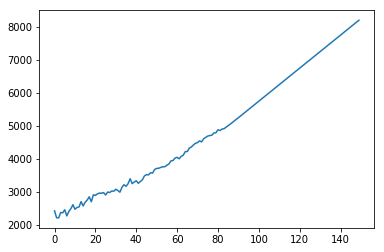

In [26]:
%time plt.plot(run_day12(index=(None,150,None), steps=3000))

Now just let it run for `50_000_000_000` iterations... let's see how that goes. Actually, no way that works! 1000 iterations take about 1s, and runtimes > 50_000_000 s are not realistic. so there has to be a trick to it.

I remembered, that the Game of Life has certain constallations that are stable/cycle between states. So I decided to look at the sums produced after a sufficient amount of iterations. While the value keeps growing indefinitely, it grows at a steady rate after a while. So we can just extrapolate the result.

sample: [15245, 15295, 15345, 15395, 15445, 15495, 15545, 15595, 15645, 15695]


2500000000695

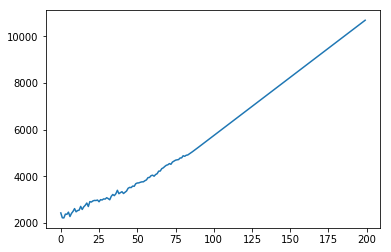

In [27]:
plt.plot(run_day12(index=(None,None,None) ,steps=200))
def long_run_day12():
    sums = run_day12(index=(None,None,None),steps=300)
    print(f"sample: {sums[-10:]}")
    def extrapolate(target):
        return (sums[200]-sums[199])*(target-200) + sums[200]
    assert sums[19] == 2911 # this should be generation 20, so the index is shifted by one
    assert extrapolate(250) == sums[250]
    assert extrapolate(275) == sums[275]
    return extrapolate(50000000000-1)
long_run_day12()

## Day 13
The elves are moving carts of produce around, moving each one one step at a time. When arriving at an intersection, each cart might turn, looping through the list `[left,straight,right]`. But they will clash sometime in the future and I have to find out where.

Going with the simple solution first, reading in the grid, finding the carts and then just moving them on top of the grid.

In [28]:
from collections import namedtuple
class Cart:
    directions = ['^','>','v','<']
    turns = [-1, 0, +1]
    def __init__(self, x, y, direction):
        self.x = x
        self.y = y
        self.direction = self.directions.index(direction)
        self.turn = 0
    def pos(self):
        return (self.x, self.y)
    def __str__(self):
        return self.directions[self.direction]
    def __repr__(self):
        return f"Cart({self.x}, {self.y}, {self.directions[self.direction]})"
    def tick(self, tracks):
        # move
        if self.direction == 0:
            self.y-=1
        elif self.direction == 2:
            self.y+=1
        elif self.direction == 3:
            self.x-=1
        elif self.direction == 1:
            self.x+=1
        # turn
        track = tracks[self.y][self.x]
        if track == '+':
            self.direction = (self.direction + self.turns[self.turn]) % 4
            self.turn = (self.turn + 1) % 3
        if track == '\\':
            # up/down -> left turn; left/right -> right turn
            if self.direction in [0,2]:
                self.direction = (self.direction + self.turns[0]) % 4
            else:
                self.direction = (self.direction + self.turns[2]) % 4
        if track == '/':
            # up/down -> right turn; left/right -> left turn
            if self.direction in [0,2]:
                self.direction = (self.direction + self.turns[2]) % 4
            else:
                self.direction = (self.direction + self.turns[0]) % 4
    
        
def print_track(tracks, carts):
    for y,l in enumerate(tracks):
        for x, c in enumerate(l):
            print(c if (x,y) not in carts else carts[(x,y)], end='')
        print()

def cart_crash_site(tracks, carts, first_crash=True):
    tick = 0
    while len(carts) > 1:
        #print("#" * 10)
        #print_track(tracks, carts)
        for cart in sorted(carts.values(), key=lambda c: (c.y,c.x)):
            if cart.pos() in carts: # could have been deleted by a crash
                del carts[cart.pos()]
            else:
                continue
            cart.tick(tracks)
            if cart.pos() in carts:
                print(f"crash @{cart.pos()} tick {tick}")
                if first_crash:
                    return cart.pos()
                else:
                    del carts[cart.pos()]
            else:
                carts[cart.pos()] = cart
        tick+=1
    return carts.values()
    #print_track(tracks, carts)
assert cart_crash_site(["---------"], {(2,0): Cart(2,0,'>'), (6,0):Cart(6,0,'<')}) == (4,0)
assert cart_crash_site(["  +----+\\/-",
                        "  +    \\-/",
                        "--+"], {(0,2): Cart(0,2,'>'), (10,0):Cart(10,0,'<')}) == (5,0)

def run_day13(lines=None, **kwargs):
    print("running day 13")
    tracks = []
    # replace carts with track
    if lines == None:
        lines = Input(13)
    carts = {}
    for y, l in enumerate(lines):
        for x, c in enumerate(l):
            if c in ['>','<','^','v']:
                carts[(x,y)] = Cart(x,y,c)
        tracks.append(l.translate(str.maketrans('><^v', '--||')))
    return cart_crash_site(tracks, carts, **kwargs)
assert run_day13(lines="""\
/->-\\        
|   |  /----\\
| /-+--+-\\  |
| | |  | v  |
\\-+-/  \\-+--/
  \\------/   \
""".split('\n')) == (7,3)
assert run_day13() == (82,104)
run_day13(first_crash=False)

crash @(4, 0) tick 1
crash @(5, 0) tick 6
running day 13
crash @(7, 3) tick 13
running day 13
crash @(82, 104) tick 153
running day 13
crash @(82, 104) tick 153
crash @(23, 135) tick 402
crash @(35, 127) tick 515
crash @(94, 10) tick 592
crash @(120, 86) tick 684
crash @(116, 22) tick 821
crash @(105, 65) tick 2844
crash @(29, 73) tick 11821


dict_values([Cart(121, 22, ^)])

Ok, my implementation worked, only the collision-detection did not. I assumed, since there is no clear statement about the order, the carts are run in, that collisions only occur if both carts end up in the same place. But the puzzle implies, that the carts are processed from **top to bottom** and **left to right**, accounting for crashes after each cart move.

Part 2 removes carts the second, before they move. What is the position of the last cart remaining?

## Day 14
The elves are using the ingredients in the carts to make cake or something. They try out different recipes, combining them. The 2 elves sum the 'value' of their current recipe, append it to the end of the list of recipes and move on to the next one. They move by `1 + value_of_current_recipe`.

I will just build up the list of recipes during iteration and return the result (the ten recipes after iterating `#in` times).

In [29]:
def next_recipe_values(recipes):
    values = [3,7]
    elf1 = 0
    elf2 = 1
    for i in range(1, recipes + 10):
        #print(f"{i}: {elf1:2d} {elf2:2d} {values}")
        if values[elf1] + values[elf2] > 9:
            values.append((values[elf1] + values[elf2])//10)
        values.append((values[elf1] + values[elf2])%10)
        elf1 = (elf1+1+values[elf1]) % len(values)
        elf2 = (elf2+1+values[elf2]) % len(values)
        if len(values) >= recipes+10:
            return "".join(map(str, values[recipes:recipes+10]))
assert next_recipe_values(5) == '0124515891'
assert next_recipe_values(9) == '5158916779'
assert next_recipe_values(18) == '9251071085'
assert next_recipe_values(2018) == '5941429882'
next_recipe_values(430971)

'5715102879'

Actually, the elves' plan was the other way around. After how many recipes does our Input appear?

The hardest part was to get the while-condition right, either ending early or not ending at all.

In [30]:
def find_input_in_recipe_values(recipes):
    final = [int(c) for c in recipes]
    values = [3,7]
    elf1 = 0
    elf2 = 1
    while len(values) < 3 or (final != values[-len(recipes):] and final != values[-len(recipes)-1:-1]):
        if values[elf1] + values[elf2] > 9:
            values.append((values[elf1] + values[elf2])//10)
        values.append((values[elf1] + values[elf2])%10)
        elf1 = (elf1+1+values[elf1]) % len(values)
        elf2 = (elf2+1+values[elf2]) % len(values)
    if final != values[-len(recipes):]:
        return len(values) - len(recipes) - 1
    if final != values[-len(recipes)-1:-1]:
        return len(values) - len(recipes)
assert find_input_in_recipe_values('01245') == 5
assert find_input_in_recipe_values('51589') == 9
assert find_input_in_recipe_values('92510') == 18
assert find_input_in_recipe_values('59414') == 2018
%time find_input_in_recipe_values('430971')

CPU times: user 15 s, sys: 46.4 ms, total: 15.1 s
Wall time: 15.1 s


20225706

## Day 15
The elves have to fight of goblins, that want to steal their chocolate. Each side follows the same strict rules (which are really long to describe). Basic idea:
- reading order for unit-order and breaking ties in decisions
- first move one step in the direction of the closest reachable enemy (if there is one + no walking through units/walls)
- attack enemies in range, the one with the lowest health first.
- HP 200, ATK 3
- combat ends if there is no enemy left.

So more simulation for me :). But this is a lot more visual, so i implement it in the terminal. Result will be: `num_full_rounds + sum(remaining_hp)`

In [31]:
%time %run d15_fighting.py -q

Part 1: 193476
atk= 8: 10 elves -> 0 survivors
atk= 9: 10 elves -> 4 survivors
atk=33: 10 elves -> 9 survivors
atk=34: 10 elves -> 10 survivors
Part 2 (minimise the necessary amount of damage for no elven casualties): 36768
CPU times: user 10.5 s, sys: 6.62 ms, total: 10.6 s
Wall time: 10.6 s


<Figure size 432x288 with 0 Axes>

The elves started winning once they did 9 damage per hit, with no casualties at 34 damage per hit. The solution is again the score of the end-position.

## Day 16